# Load Data

In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.append('../')
import pandas as pd
import tqdm
import warnings
import copy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import networkx as nx
import numpy as np
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
## Configure file and folder names
datafolder = "../data"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "FIFA World Cup"]
print("nb of games:", len(games))

nb of games: 64


# Helper Functions

In [4]:
def players_in_pos(pos):
    contribution_action = ['pass', 'dribble', 'throw_in', 'corner_crossed', 'freekick_crossed', 'cross', 'shot', 
                  'freekick_short', 'goalkick', 'corner_short', 'shot_penalty']
    
    pos_players = []
    team = None
    
    for play in pos:
        player = play['player_name']
        if play['type_name'] in contribution_action and play['result_name'] == 'success':
            team = play['team_name']
            if player not in pos_players:
                pos_players.append(player)
    
    return pos_players, team

In [5]:
def change_possession(action, action_team, possession_team, result):
    end_pos = ['bad_touch', 'foul']
    change_team = ['pass', 'dribble', 'throw_in', 'corner_crossed', 'freekick_crossed', 'cross', 'shot', 
                  'freekick_short', 'goalkick', 'corner_short', 'shot_penalty', 'keeper_pick_up']
    success_change = ['tackle', 'interception', 'take_on', 'clearance', 'keeper_claim', 'keeper_save', 
                      'keeper_punch']
    
    if possession_team == None:
        if result == 'success':
            if action in change_team:
                possession_team = action_team
        else:
            return False, None
    
    
    if action in end_pos:
        return True, None
    
    if action_team != possession_team:
        if action in change_team:
            return True, action_team
        if result == 'success':
            if action in success_change:
                return True, action_team
            
    return False, possession_team

In [6]:
def extract_possessions(actions):
    all_possessions = []
    curr_possession = []
    team1 = []
    team2 = []
    
    
    possessing_team = actions.loc[0]["team_name"]
    team1_name = actions.loc[0]["team_name"]
    
    for i in range(len(actions)):
        # Extract possession
        action = actions.loc[i]["type_name"]
        action_team = actions.loc[i]["team_name"]
        
        if action_team != team1_name:
            team2_name = action_team
        
        result = actions.loc[i]["result_name"]
        end_pos, possessing_team = change_possession(action, action_team, possessing_team, result)
        
        if end_pos:
            all_possessions.append(copy.deepcopy(curr_possession))
            curr_possession = []

        curr_possession.append(actions.loc[i])
        
        # Identify players
        if (len(team1) == 14 and len(team2) == 14):
            continue
        
        player = actions.loc[i]["player_name"]
        if action_team == team1_name:
            if player not in team1:
                team1.append(player)
        else:
            if player not in team2:
                team2.append(player)

    return all_possessions, team1, team2, team1_name, team2_name

In [7]:
def pos_pass_list(pos):
    edges = []
    pass_action = ['pass', 'throw_in', 'corner_crossed', 'freekick_crossed', 'cross', 
                  'freekick_short', 'goalkick', 'corner_short']
    
    for i in range(len(pos)):
        action = pos[i]
          
        if action["type_name"] in pass_action:
            if action["result_name"] == 'success':
                passer = action["player_name"]
                team = action["team_name"]
                j = 1
                while i+j < len(pos) and (pos[i+j]["team_name"] != team):
                    j += 1
                try:
                    passer = action["player_name"]
                    receiver = pos[i+j]["player_name"]
                    edges.append((passer, receiver))
                except:
                    continue
                
    return edges

In [8]:
def create_graph(passes):
    G = nx.DiGraph((x, y, {'weight': v}) for (x, y), v in Counter(passes).items())
    return G

In [9]:
def get_total_links(G):
    DV = G.degree(weight='weight')
    return sum(deg for n, deg in DV)/2.0

In [10]:
def get_metrics(G):
    total_links = get_total_links(G)
    density = nx.density(G)
    
    return total_links, density

In [11]:
def compute_average(player_metrics):
    average = {}
    
    for player in player_metrics:
        if len(player_metrics[player][0]) < 5:
            continue
        
        average[player] = [np.mean(player_metrics[player][0]), np.mean(player_metrics[player][1])]
    
    return average

In [110]:
def compute_difference(pos_metrics, team_props, roster):
    difference = {}
    
    for player in pos_metrics:
        if len(pos_metrics[player][0]) < 50:
            continue
            
        try:
            team = roster[player]
            diff1 = np.mean(pos_metrics[player][0]) - np.mean(team_props[team][0])
            diff2 = np.mean(pos_metrics[player][1]) - np.mean(team_props[team][1])
            std1 = np.std(team_props[team][0])
            std2 = np.std(team_props[team][1])
            difference[player] = [diff1 / std1, diff2 / std2]
            
        except:
            continue
    
    return difference

In [13]:
def world_cup_team_placements():
    placements = {}
    placements['France'] = 1.5
    placements['Croatia'] = 1.5
    placements['Belgium'] = 3.5
    placements['England'] = 3.5
    placements['Uruguay'] = 6.5
    placements['Brazil'] = 6.5
    placements['Russia'] = 6.5
    placements['Sweden'] = 6.5
    placements['Portugal'] = 12.5
    placements['Argentina'] = 12.5
    placements['Mexico'] = 12.5
    placements['Japan'] = 12.5
    placements['Spain'] = 12.5
    placements['Denmark'] = 12.5
    placements['Switzerland'] = 12.5
    placements['Colombia'] = 12.5
    placements['Saudi Arabia'] = 24.5
    placements['Iran'] = 24.5
    placements['Peru'] = 24.5
    placements['Nigeria'] = 24.5
    placements['Serbia'] = 24.5
    placements['South Korea'] = 24.5
    placements['Tunisia'] = 24.5
    placements['Senegal'] = 24.5
    placements['Egypt'] = 24.5
    placements['Morocco'] = 24.5
    placements['Australia'] = 24.5
    placements['Iceland'] = 24.5
    placements['Costa Rica'] = 24.5
    placements['Germany'] = 24.5
    placements['Panama'] = 24.5
    placements['Poland'] = 24.5
    
    return placements

# Compute Network Metrics

In [14]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

In [106]:
pos_metrics = {}
not_pos_metrics = {}
team_props = {}
roster = {}

for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .merge(players,"left",on="player_id")
        .merge(teams,"left",on="team_id")
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    
    possessions, team1, team2, team1_name, team2_name = extract_possessions(actions)
    
    for player in team1:
        if player not in roster:
            roster[player] = team1_name
    for player in team2:
        if player not in roster:
            roster[player] = team2_name
           
    for pos in possessions:
        pos_players, pos_team = players_in_pos(pos)
        
        if pos_team is None:
            continue
        
        passes = pos_pass_list(pos)
        
        if len(passes) < 7:
            continue
        
        G = create_graph(passes)
        
        total_links, density = get_metrics(G)
        
        if pos_team in team_props:
            team_props[pos_team][0].append(total_links)
            team_props[pos_team][1].append(density)
        else:
            team_props[pos_team] = [[total_links], [density]]
        
        if pos_team == team1_name:
            for player in team1:
                if player in pos_players:
                    if player in pos_metrics:
                        pos_metrics[player][0].append(total_links)
                        pos_metrics[player][1].append(density)
                    else:
                        pos_metrics[player] = [[total_links], [density]] 
                else:
                    if player in not_pos_metrics:
                        not_pos_metrics[player][0].append(total_links)
                        not_pos_metrics[player][1].append(density)
                    else:
                        not_pos_metrics[player] = [[total_links], [density]] 
        else:
            for player in team2:
                if player in pos_players:
                    if player in pos_metrics:
                        pos_metrics[player][0].append(total_links)
                        pos_metrics[player][1].append(density)
                    else:
                        pos_metrics[player] = [[total_links], [density]] 
                else:
                    if player in not_pos_metrics:
                        not_pos_metrics[player][0].append(total_links)
                        not_pos_metrics[player][1].append(density)
                    else:
                        not_pos_metrics[player] = [[total_links], [density]] 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [01:39<00:00,  1.63s/it]


In [111]:
team_avg = compute_average(team_props)
difference = compute_difference(pos_metrics, team_props, roster)
placements = world_cup_team_placements()

# Placements

In [112]:
import scipy.stats as stats

In [113]:
place = [24.5, 12.5, 6.5, 3.5, 1.5]

total_links = {}
density = {}

for p in place:
    total_links[p] = []
    density[p] = []
    
for team in team_props:
    total_links[placements[team]] += team_props[team][0]
    density[placements[team]] += team_props[team][1]
    
for p in place:
    print("Placement:", p)
    print("Total Links:", np.mean(total_links[p]))
    print("Density:", np.mean(density[p]))
    print()

Placement: 24.5
Total Links: 10.968707482993198
Density: 0.2500701868048807

Placement: 12.5
Total Links: 11.894805194805194
Density: 0.24665195554805944

Placement: 6.5
Total Links: 11.056666666666667
Density: 0.24624025974025973

Placement: 3.5
Total Links: 11.988919667590027
Density: 0.2478111147086216

Placement: 1.5
Total Links: 10.85
Density: 0.24431006493506494



# Group vs Knockout ANOVA Test

In [114]:
net1 = []
net2 = []

for i in range(1, len(place)):
    net1 += total_links[place[i]]
    net2 += density[place[i]]

f_scores = []    

f_scores.append(stats.f_oneway(total_links[24.5], net1))
f_scores.append(stats.f_oneway(density[24.5], net2))

for f in f_scores:
    print(f)

F_onewayResult(statistic=7.8563867893273835, pvalue=0.0051040953229766)
F_onewayResult(statistic=1.001564167459519, pvalue=0.31703139415704923)


# Quarters vs Semis ANOVA Test 

In [115]:
f_scores = []    

f_scores.append(stats.f_oneway(total_links[6.5], total_links[3.5]+total_links[1.5]))
f_scores.append(stats.f_oneway(density[6.5], density[3.5]+density[1.5]))

for f in f_scores:
    print(f)

F_onewayResult(statistic=1.5492965438142214, pvalue=0.2135498852318521)
F_onewayResult(statistic=5.3499388018310195e-05, pvalue=0.9941656165922687)


# Total Links 

In [116]:
count_teams = {}
for team in placements:
    count_teams[team] = 2

ordered_players = OrderedDict(sorted(difference.items(), key=lambda x: x[1][0], reverse=True))
for player in ordered_players:
    team = roster[player]
    if count_teams[team] > 0:
        print(player + " (" + team + ") : " + str(ordered_players[player][0]))
        count_teams[team] -= 1

Ruben Loftus-Cheek (England) : 0.3653559726903612
Raheem Shaquille Sterling (England) : 0.3351490067069765
Nacer Chadli (Belgium) : 0.328324919818889
Ivan Perišić (Croatia) : 0.3185831765547338
Marouane Fellaini-Bakkioui (Belgium) : 0.27595320203922724
David Josué Jiménez Silva (Spain) : 0.2690360339255903
Xherdan Shaqiri (Switzerland) : 0.2499793287119721
Diego Roberto Godín Leal (Uruguay) : 0.23534010540575204
Antoine Griezmann (France) : 0.21009595057714622
Nicolás Alejandro Tagliafico (Argentina) : 0.18241763940192682
Neymar da Silva Santos Junior (Brazil) : 0.17692269071579206
José Martín Cáceres Silva (Uruguay) : 0.17174674047917005
N"Golo Kanté (France) : 0.16443712296940768
Willian Borges da Silva (Brazil) : 0.16060934732915771
Jorge Resurrección Merodio (Spain) : 0.16038995312652488
Salman Mohammed Al Faraj (Saudi Arabia) : 0.15891621474853992
Salem Mohammed Al Dawsari (Saudi Arabia) : 0.1462861275548739
Johan Andrés Mojica Palacio (Colombia) : 0.12725578233616017
Valon Behram

# Density

In [117]:
count_teams = {}
for team in placements:
    count_teams[team] = 2

ordered_players = OrderedDict(sorted(difference.items(), key=lambda x: x[1][1], reverse=False))
for player in ordered_players:
    team = roster[player]
    if count_teams[team] > 0:
        print(player + " (" + team + ") : " + str(ordered_players[player][1]))
        count_teams[team] -= 1

Jordan Pickford (England) : -0.3113434445628661
Johan Andrés Mojica Palacio (Colombia) : -0.30729164572292716
Marouane Fellaini-Bakkioui (Belgium) : -0.28571022920577477
Phil Jones (England) : -0.2624927502806859
Hiroki Sakai (Japan) : -0.2539543262482179
Antoine Griezmann (France) : -0.24847486823202206
David Josué Jiménez Silva (Spain) : -0.24386096361149232
José Paulo Bezzera Maciel Júnior (Brazil) : -0.24318402778946882
Gaku Shibasaki (Japan) : -0.20848140243464341
Thibaut Courtois (Belgium) : -0.2071433215277528
Neymar da Silva Santos Junior (Brazil) : -0.19970093581877982
Lucas Hernández Pi (France) : -0.19613900740212464
Jérôme Boateng (Germany) : -0.19055107575228983
Xherdan Shaqiri (Switzerland) : -0.18770329271022848
Šime Vrsaljko (Croatia) : -0.1700968420427116
Yasir Gharsan Al Shahrani (Saudi Arabia) : -0.16716877502227992
José Martín Cáceres Silva (Uruguay) : -0.15372251264493547
Marcelo Brozović (Croatia) : -0.1407410779566425
Faustino Marcos Alberto Rojo (Argentina) : -0

# World Cup Team Possession Regression 

In [118]:
from scipy import stats

In [119]:
ordered_teams = OrderedDict(sorted(team_avg.items(), key=lambda x: x[1][0], reverse=True))
metrics = ["Total Links", "Density"]

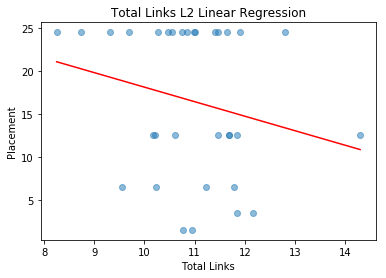

slope: -1.6920794727104302
r: -0.22884606855624628
p: 0.2077261410432903
std_err 1.314122812044137



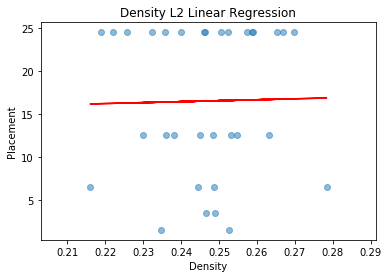

slope: 11.088685533481197
r: 0.019063722028715528
p: 0.9175190230204795
std_err 106.17757738556831



In [120]:
for i in range(2):

    X = []
    y = []

    for team in ordered_teams:
        X.append(ordered_teams[team][i])
        y.append(placements[team])

    slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)
    
    yPred1 = [intercept + slope * x for x in X]
    plt.scatter(X, y,alpha=0.5)
    plt.plot(X, yPred1, 'r', label="Linear")
    plt.title(metrics[i] + " L2 Linear Regression")
    plt.ylabel("Placement")
    plt.xlabel(metrics[i])
    plt.show()
    
    print("slope:", slope)
    print("r:", r_value)
    print("p:", p_value)
    print("std_err", std_err)
    print()